# Tarea 5: Redes Recurrentes <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: José Manuel Rubio Cienfuegos
Fecha de entrega: 30 de diciembre de 2020

In [ ]:
import os

import torch
import torchvision

from collections import Counter
from torchvision import  
import matplotlib.pyplot as plt

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea5/utils.py -q --show-progress

utils.py            100%[===================>]   4.10K  --.-KB/s    in 0s      


In [ ]:
from utils import extract_text_from_set, extract_text_from_set, tokenize_text 
from utils import encode_sentences, pad_sequence_with_lengths, pad_sequence_with_images
from utils import TextDataset, CaptioningDataset

# Parte 1: Generación de texto

### Datos

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
    print('*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
    print('****** Descargando las imágenes...')
    !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images -q --show-progress 
    print('********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
    !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
    print('*** Descargando anotaciones de las imágenes...')
    !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations -q --show-progress

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset', ann_file = f'{folder_path}/annotations/8k-pictures.html')

print('Creando train, val y test splits...')
train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)

print('Listo!')

*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...
Flickr8k_Dataset.zi  96%[==================> ]   1.01G  5.38MB/s    in 4m 17s  
Flickr8k_Dataset.zi 100%[+++++++++++++++++++>]   1.04G  7.66MB/s    in 4.8s    
********* Extrayendo las imágenes...
  Si te sale mensaje de colab, dale Ignorar

*** Descargando anotaciones de las imágenes...
8k-pictures.html    100%[===================>]   3.53M  6.70MB/s    in 0.5s    
Inicializando pytorch Flickr8k dataset
Creando train, val y test splits...
Listo!


#### Extrae los textos

In [ ]:
train_text = extract_text_from_set(train_flickr_set)
val_text = extract_text_from_set(val_flickr_set)
test_text = extract_text_from_set(test_flickr_set)

100%|██████████| 663/663 [00:00<00:00, 414615.11it/s]


In [ ]:
train_text[0]

'A child in a pink dress is climbing up a set of stairs in an entry way.'

#### Genera los tokens

In [ ]:
tokenizer = get_tokenizer('spacy')
counter = Counter()  # para llevar la cuenta de los tokens y su ocurrencia

train_tokens, counter = tokenize_text(train_text, tokenizer, counter)
test_tokens, counter = tokenize_text(test_text, tokenizer, counter)
val_tokens, counter = tokenize_text(val_text, tokenizer, counter)

#### Define el vocabulario y agrega `<pad>` y `<sos>`

In [ ]:
vocab = list(counter.keys())
vocab.append('<pad>')
vocab.append('<sos>')
word2idx = {word: i for i, word in enumerate(vocab)}
pad_idx = word2idx['<pad>']

#### Convierte oraciones a ids y genera los dataset de entrenamiento

In [ ]:
train_sentences = encode_sentences(train_tokens, vocab, word2idx)
test_sentences = encode_sentences(test_tokens, vocab, word2idx)
val_sentences = encode_sentences(val_tokens, vocab, word2idx)

train_dataset = TextDataset(train_sentences)
test_dataset = TextDataset(test_sentences)
val_dataset = TextDataset(val_sentences)

Con todo lo anterior, además de tener los dataset para entrenamiento, podemos también obtener identificadores correspondientes a textos que nosotros decidamos, haciendo algo como lo siguiente:

In [ ]:
s1 = 'A woman holding a cup of tea.'
s2 = 'A man with a dog.'

S = [s1,s2]
tokens, _ = tokenize_text(S, tokenizer)
D = encode_sentences(tokens, vocab, word2idx)

print('tokens:', tokens)
print('ids:', D)

tokens: [['<sos>', 'a', 'woman', 'holding', 'a', 'cup', 'of', 'tea', '.'], ['<sos>', 'a', 'man', 'with', 'a', 'dog', '.']]
ids: [[8460, 0, 238, 94, 0, 1570, 9, 1022, 14], [8460, 0, 78, 36, 0, 27, 14]]


#### Creamos los data loaders (puedes cambiar el tamaño del batch si lo deseas)



In [ ]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))

**IMPORTANTE**: Nuestros datasets y dataloaders consideran también los largos de las secuencias. El siguiente código obtiene el primer elemento del dataset y el primer elemento del dataloader de prueba. Nota que lo que entregan en ambos casos es un par: la primera componente del par tiene los datos (los índices) mientras que la segunda componente tiene información de los largos de las secuencias.

In [ ]:
d, length = test_dataset[0]
print('len(d):', len(d))
print('length:', length)

len(d): 13
length: 13


In [ ]:
# Obtiene un paquete desde el dataloader
for data in test_dataloader:
  D, Lengths = data
  break

print(D.size())
print(Lengths.size())

# La primera dimensión de D corresponde al largo
# máximo de las secuencias en el batch
assert D.size()[0] == torch.max(Lengths)

# La segunda dimensión de D corresponde al tamaño del
# batch, al igual que la dimensión de Lengths
assert D.size()[1] == batch_size 
assert Lengths.size()[0] == batch_size

torch.Size([25, 64])
torch.Size([64])


## 1a) Red recurrente

### RNN

In [ ]:
# Acá empieza tu código

class RedRecurrente(torch.nn.Module):
    def __init__(self, RNN_type = 'RNN', vocab_size=10000, emb_dim=100, rec_dim=30, rec_layers=3, 
        pad_value=8459, p_drop=.5, batch_size=64): # Piensa en todo lo que necesitas para incializar.
        # Crea las capas considerando al menos los puntos de arriba.
        super(RedRecurrente, self).__init__()
        self.emb_layer = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_value)
        if RNN_type == 'RNN':  
          self.R_layer = nn.RNN(emb_dim, rec_dim, rec_layers)
        elif RNN_type == 'GRU':
          self.R_layer = nn.GRU(emb_dim, rec_dim, rec_layers)
        elif RNN_type == 'LSTM':
          self.R_layer = nn.LSTM(emb_dim, rec_dim, rec_layers)
        else:
          print('Invalid RNN type.')
        self.out_layer = nn.Linear(rec_dim, vocab_size)
        self.dropout = nn.Dropout(p=p_drop)
        self.BN = nn.BatchNorm1d(batch_size)
        self.BN_2 = nn.BatchNorm1d(48)
        self.BN_3 = nn.BatchNorm1d(8)
        self.BN_predict = nn.BatchNorm1d(1)

    def forward(self, x, h_0=None, predict=False):
        # Acá debes programar la pasada hacia adelante.
        # El vector h_0 deberías simplemente pasarlo directo
        # a tu red recurrente (RNN, o GRU, o LSTM) y será necesario
        # para trabajar en la sección (1c) y en la parte 2. 
        # También puedes usar dropout, batch normalization o lo que necesites.
        b_size = x.size()[1]
        x = self.emb_layer(x)
        x, h = self.R_layer(x)
        if predict:
          x = self.BN_predict(x)
        else:
          if b_size == 64:
            x = self.BN(x)
          elif b_size == 48:
            x = self.BN_2(x)
          else:
            x = self.BN_3(x)
        x = self.dropout(x)
        logits = self.out_layer(x)
        return logits

## 1b) Entrenamiento

In [ ]:
# Acá tu código para el loop de entrenamiento
# y los gráficos de la pérdida

import sys
 
# indice de padding y tamaño de vocabulario de ejemplo
pad_idx = 8459
voc_size = len(vocab)

RNN = RedRecurrente(RNN_type='LSTM', vocab_size=voc_size, emb_dim=100, rec_dim=120, rec_layers=3, p_drop=0.2)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, reduction='mean')
optimizer = optim.Adam(RNN.parameters())

RNN = RNN.to('cuda')

epochs = 7
loss_train, loss_val = [], []

for epoch in range(epochs):
  RNN.train()
  running_loss = 0.0

  for i, data in enumerate(train_dataloader):
  # for i, data in enumerate(train_dataloader):
    X, length = data
    X, Y = X[:-1, :].to('cuda'), X[1:,:].to('cuda')
    optimizer.zero_grad()
    Y_pred = RNN(X).view(-1, voc_size)
    # print(Y_pred.size())
    # print(Y.size())
    loss = criterion(Y_pred, Y.view(-1))
    loss.backward()
    optimizer.step()

    # Cálculo y reporte de coste.
    items = (i+1) * batch_size
    running_loss += loss.item()
    info = f'\rEpoch:{epoch+1}({items}/{30016}), '
    info += f'Train Loss:{running_loss/(i+1):02.5f}, '
    sys.stdout.write(info)

  loss_train.append(running_loss/468.99)

  with torch.no_grad():
  # RNN.eval()
    for data_v in val_dataloader:
      X_v, len_v = data_v
      X_v, Y_v = X_v[:-1,:].to('cuda'), X_v[1:,:].to('cuda')
      Yv_pred = RNN(X_v).view(-1, voc_size)
      loss_v = criterion(Yv_pred, Y_v.view(-1))
    info = f'Val loss:{loss_v}.\n'
    sys.stdout.write(info)
    loss_val.append(loss_v.cpu().numpy().reshape(1,)[0])
    
print('loss train: ',loss_train)
print('loss val: ', loss_val)

Epoch:1(30016/30016), Train Loss:4.33954, Val loss:5.483774185180664.
Epoch:2(30016/30016), Train Loss:3.38867, Val loss:5.317324638366699.
Epoch:3(30016/30016), Train Loss:3.12403, Val loss:5.206422805786133.
Epoch:4(30016/30016), Train Loss:2.96066, Val loss:5.232067108154297.
Epoch:5(30016/30016), Train Loss:2.83912, Val loss:5.249197006225586.
Epoch:6(30016/30016), Train Loss:2.73679, Val loss:5.254299640655518.
Epoch:7(30016/30016), Train Loss:2.64865, Val loss:5.27931022644043.
loss train:  [4.339629814958732, 3.388739678419415, 3.1241001087749063, 2.96072384582079, 2.839179292066069, 2.736844826655621, 2.6487076454583116]
loss val:  [5.483774, 5.3173246, 5.206423, 5.232067, 5.249197, 5.2542996, 5.27931]


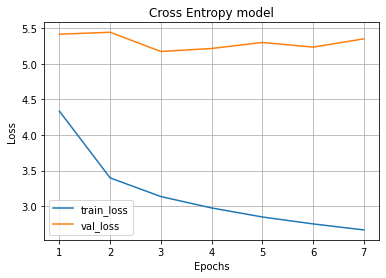

In [ ]:
Epochs = range(1,epochs+1)
plt.plot(Epochs, loss_train, label='train_loss')
plt.plot(Epochs, loss_val, label='val_loss')
plt.title('Cross Entropy model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 1c) Generación de texto

In [ ]:
from torch.distributions.categorical import Categorical

In [ ]:
# Acá tu código para generar texto usando el modelo

def generate_sentence(model, init_sentence, max_length, sample=False):
  global vocab, word2idx, tokenizer, voc_size, token_id
  # Usa acá lo que necesites para crear una secuencia de
  # salida. Muy posiblemente tendrás que usar un tokenizador
  # y el diccionario para pasar de índices a tokens (palabras).
  sentence = init_sentence
  for k in range(max_length):
    init_tokens, _ = tokenize_text([sentence], tokenizer)
    Data = torch.tensor(encode_sentences(init_tokens, vocab, word2idx)).cuda()
    logits_data = model.forward(Data.T, predict=True).view(-1, voc_size)
    logits_index_max = torch.max(F.softmax(logits_data, dim=1), dim=1)[1]
    if sample:
      next_word = vocab[token_id[logits_index_max[-2]]]
    else:
      next_word = vocab[logits_index_max[-2]]
    if next_word == '.':
      sentence += next_word
      break
    else:
      sentence += ' ' + next_word 
  return sentence

### Ejemplos de generación de texto.

In [ ]:
model = RNN

sentence_1 = val_text[0]
sentence_2 = val_text[20]
sentence_3 = val_text[70]

len_cut = 4

sentence_1_cut, sentence_2_cut = sentence_1.split()[:len_cut], sentence_2.split()[:len_cut]
sentence_3_cut = sentence_3.split()[:len_cut]

sent_1c, sent_2c, sent_3c = '', '', ''

for k in range(len_cut):
  if k == len_cut - 1:
    sent_1c += sentence_1_cut[k]
    sent_2c += sentence_2_cut[k]
    sent_3c += sentence_3_cut[k]
  else:
    sent_1c += sentence_1_cut[k] + ' '
    sent_2c += sentence_2_cut[k] + ' '
    sent_3c += sentence_3_cut[k] + ' '

generate_length = 15

generate_1 = generate_sentence(model, sent_1c, generate_length)
generate_2 = generate_sentence(model, sent_2c, generate_length)
generate_3 = generate_sentence(model, sent_3c, generate_length)

print('Sentences:')
print(sentence_1)
print(sentence_2)
print(sentence_3)

print('------------------------------------------------------')

print('Sentences cut')
print(sent_1c)
print(sent_2c)
print(sent_3c)

print('------------------------------------------------------')
print('Sentences generated:')
print(generate_1)
print(generate_2)
print(generate_3)

Sentences:
A man in blue jumping a dirt bike.
A professional wrestler falls outside the ring.
A person in a yellow shirt and jeans is running on a track.
------------------------------------------------------
Sentences cut
A man in blue
A professional wrestler falls
A person in a
------------------------------------------------------
Sentences generated:
A man in blue is standing on a sidewalk with a woman in a city.
A professional wrestler falls to the finish of a man in a blue shirt and a woman holding a
A person in a red and white helmet is riding a bicycle on a trail.


## 1d) Opcional: Beam Search

In [ ]:
# Acá tu código para generar texto usando beam search

def beam_search_generation(model, init_sentence, K, ...):
  # El K representa al ancho del beam para la búsqueda.
  return sentence

# Parte 2 (Opcional): Subtitulado de imágenes

#### Generamos transformación para el dataset

Algo importante es que estamos usando la normalización estándar para los modelos pre-entrenados que provee pytoch. Si vas a usar algún otro modelo (o incluso uno generado por ti), podrías necesitar otra normalización. También nota que estamos usando el tamaño estándar de `224x224` para las imágenes que reciben los modelos pre-entrenados de pytorch. Si no quieres usar esos modelos o si quieres hacer el entrenamiento más rápido, puedes cambiarle la resolución a las imágenes.

In [ ]:
transform = transforms.Compose(
            [
              transforms.ToTensor(), 
              transforms.Resize((224, 224)),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], 
                  std=[0.229, 0.224, 0.225])
            ])

#### Creamos los data loaders (puedes cambiar el tamaño del batch si lo deseas)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
    CaptioningDataset(
        train_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

test_dataloader = DataLoader(
    CaptioningDataset(
        test_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

val_dataloader = DataLoader(
    CaptioningDataset(
        val_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

**IMPORTANTE**: Nuestros dataloaders ahora contienen las secuencias de identificadores de los tokens del texto, los largos de las secuencias y las imágenes correspondientes. El siguiente código obtiene el primer elemento del dataloader de prueba. Nota que lo que entregan en ambos casos es una tripleta: la primera componente tiene los datos desde los textos (los índices), la segunda componente tiene información de los largos de las secuencias, y la tercera componente la información de las imágenes.

In [ ]:
# Obtiene un paquete desde el dataloader
for data in test_dataloader:
  Text, Lengths, Img = data
  break

print(Text.size())
print(Lengths.size())
print(Img.size())

# La primera dimensión de Text corresponde al largo
# máximo de las secuencias en el batch
assert Text.size()[0] == torch.max(Lengths)

# La segunda dimensión de D corresponde al tamaño del
# batch, al igual que la dimensión de Lengths y la primera
# dimensión de Img
assert Text.size()[1] == batch_size 
assert Lengths.size()[0] == batch_size
assert Img.size()[0] == batch_size

### Usando modelos pre-entrenados

El siguiente código carga VGG16 (pre-entrenado), pasa el modelo a la GPU. 

In [ ]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.to('cuda')

Con un codigo como el siguiente podemos calcular las características para las imágenes `Img` del batch que obtuvimos más arriba. Nota el uso de `.eval()` y `with torch.no_grad()`.

In [ ]:
Img = Img.to('cuda')

vgg16.eval()
with torch.no_grad():
  F = vgg16.features(Img)

print(F.size())

Finalmente y por si lo necesitas, puedes acceder a las imágenes originales del dataloader haciendo algo como esto:

In [ ]:
val_dataloader.dataset.original_image(0)

## 2a) Red convolucional + recurrente

In [ ]:
class CaptioningModel(torch.nn.Module):
    def __init__(self, ...): 
        # Crea las capas considerando una parte que procese debe procesar
        # la imagen de entrada y otra que debe producir el texto (índices)
        # de salida.
        pass
        
    def forward(self, ...):
        # Acá debes programar la pasada hacia adelante.
        # Debes decidir qué le pasarás a la red y cómo haras la 
        # computación hacia adelante. Considera que no solo
        # debes entrenar los parámetros sino que además debes
        # después ser capaz de generar una secuencia de salida
        # desde una imagen de entrada.
        return ...   

## 2b) Entrenamiento

In [ ]:
# Acá tu código para el loop de entrenamiento
# y los gráficos de la pérdida

## 2c) Generando texto desde imágenes de prueba


In [ ]:
# Acá tu código para generar texto usando desde imágenes
# y un par de ejemplos con las imágenes del conjunto de prueba